ALUNOS

- **Gabriela Cruz Targino**
- **Keven Alison dos Santos Bezerra**

# 0. Preparação do Ambiente

In [1]:
!pip install wikipedia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from operator import itemgetter
import networkx as nx
import wikipedia
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# 1. Data Pipeline

Resumidamente, um Data Pipeline serve para processar os dados em diferentes etapas. O nosso projeto tem como objetivo construir uma rede a partir de uma página da wikipedia. Tendo isso em vista, construíremos um data pipeline para atender a esse objetivo com as seguintes etapas:

1.   Coletar os dados e construir a rede;
2.   Eliminar as duplicatas;
3.   Truncar a rede;
4.   Explorar a rede (a partir de diferentes grafos).



### 1.1 Coletar os dados
Inicialmente, é necessário informar uma SEED, que se trata do nosso ponto de partida para gerar o grafo referente ao assunto do nosso interesse. Em seguida declaramos os STOPS, que são nossos pontos de parada, reconhecidos como os nós folhas do grafo, onde a recursão será parada e não serão buscadas novas páginas a partir do ponto. Para o nosso trabalho utilizamos uma págica da Wikipedia referente à um álbum musical.

In [3]:
SEED = "Know by Heart".title()
STOPS = ("International Standard Serial Number",
         "International Standard Book Number",
         "National Diet Library",
         "International Standard Name Identifier",
         "International Standard Book Number (Identifier)",
         "Pubmed Identifier", 
         "Pubmed Central",
         "Digital Object Identifier", 
         "Arxiv",
         "Proc Natl Acad Sci Usa", 
         "Bibcode",
         "Library Of Congress Control Number", 
         "Jstor",
         "Doi (Identifier)",
         "Isbn (Identifier)",
         "Pmid (Identifier)",
         "Arxiv (Identifier)",
         "Bibcode (Identifier)")

In [4]:
todo_lst = [(0, SEED)] # The SEED is in the layer 0
todo_set = set(SEED) # The SEED itself
done_set = set() # Nothing is done yet

Nas próximas etapas, o grafo será criado e armazenado na variável g. Contudo, ele ainda não estará adequado para manipulação, devido à presença de muitas informações desnecessárias.

In [5]:
g = nx.DiGraph()
layer, page = todo_lst[0]

In [6]:
%%time
while layer < 2:
  # Remove the name page of the current page from the todo_lst, 
  # and add it to the set of processed pages. 
  # If the script encounters this page again, it will skip over it.
  del todo_lst[0]
  done_set.add(page)
  
  # Show progress
  print(layer, page) 
  
  # Attempt to download the selected page.
  try:
    wiki = wikipedia.page(page)
  except:
    print("Could not load", page)
    layer, page = todo_lst[0]
    continue
  
  for link in wiki.links:
    link = link.title()
    if link not in STOPS and not link.startswith("List Of"):
      if link not in todo_set and link not in done_set:
        todo_lst.append((layer + 1, link))
        todo_set.add(link)
      g.add_edge(page, link)
  layer, page = todo_lst[0]

0 Know By Heart
1 Album
1 Allmusic
1 Andrew Kenny (Singer)
1 Ben Gibbard
Could not load Ben Gibbard
1 Cmj New Music Monthly
1 Death Cab For Cutie
1 Home Volume V
1 Indie Rock
1 Mbrg (Identifier)
1 Music Genre
1 Pitchforkmedia
1 Promise Of Love
1 Record Label
1 Record Producer
Could not load Record Producer
1 The American Analog Set
1 The Fun Of Watching Fireworks
1 The Golden Band
1 The Postal Service
1 The Time Traveler'S Wife (Film)
1 Tiger Style Records
CPU times: user 1.7 s, sys: 90 ms, total: 1.79 s
Wall time: 15.6 s


In [7]:
print("N° nós: {}".format(len(g)))
print("N° Vértices: {}".format(nx.number_of_edges(g)))

N° nós: 2202
N° Vértices: 3012


### 1.2 Eliminar as duplicatas
Para iniciar a limpeza da rede, primeiro faremos a eliminação de páginas que se referem a elas mesmas e de nós com o mesmo nome.

In [8]:
# make a copy of raw graph
original = g.copy()

In [9]:
# remove self loops
g.remove_edges_from(nx.selfloop_edges(g))

# identify duplicates like that: 'network' and 'networks'
duplicates = [(node, node + "s") 
              for node in g if node + "s" in g
             ]

for dup in duplicates:
  # *dup is a technique named 'unpacking'
  g = nx.contracted_nodes(g, *dup, self_loops=False)

print(duplicates)

duplicates = [(x, y) for x, y in 
              [(node, node.replace("-", " ")) for node in g]
                if x != y and y in g]
print(duplicates)

for dup in duplicates:
  g = nx.contracted_nodes(g, *dup, self_loops=False)

# nx.contracted creates a new node/edge attribute called contraction
# the value of the attribute is a dictionary, but GraphML
# does not support dictionary attributes
nx.set_node_attributes(g, 0,"contraction")
nx.set_edge_attributes(g, 0,"contraction")

[('B-Side', 'B-Sides')]
[]


In [10]:
print("N° nós: {}".format(len(g)))
print("N° Vértices: {}".format(nx.number_of_edges(g)))

N° nós: 2201
N° Vértices: 3009


### 1.3 Truncar a rede
Para esta etapa, faremos a remoção de nós com duas conexões ou menos. Isso será feito aplicando um filtro que selecionará apenas os nós com grau maior ou igual a 3.

In [11]:
# filter nodes with degree greater than or equal to 3
core = [node for node, deg in dict(g.degree()).items() if deg >= 3]

# select a subgraph with 'core' nodes
g2 = nx.subgraph(g, core)

print("{} nodes, {} edges".format(len(g2), nx.number_of_edges(g2)))

nx.write_graphml(g2, "cna.graphml")

99 nodes, 359 edges


In [12]:
print("Nodes removed: {:.2f}%".format(100*(1 - 3296/13526)))
print("Edges removed: {:.2f}%".format(100*(1 - 14494/24724)))
print("Edges per nodes: {:.2f}".format(13526/3296))

Nodes removed: 75.63%
Edges removed: 41.38%
Edges per nodes: 4.10


### 1.4 Explorar a rede
Após a limpeza dos dados, podemos agora explorar a rede obtida e realizar diferentes análises.

In [13]:
top_indegree = sorted(dict(g2.in_degree()).items(),
                      reverse=True, key=itemgetter(1))[:100]
print("\n".join(map(lambda t: "{} {}".format(*reversed(t)), top_indegree)))

9 Indie Rock
7 Record Label
7 Wayback Machine
6 Compact Disc
6 The American Analog Set
6 Music Genre
6 Allmusic
6 Extended Play
6 Album
6 Record Producer
5 Rock Music
5 Rolling Stone
5 Issn (Identifier)
5 S2Cid (Identifier)
5 Independent Record Label
5 Mba (Identifier)
4 A-Side And B-Side
4 Punk Rock
4 Music Festival
4 Isni (Identifier)
4 Pitchfork (Website)
4 Uk Singles Chart
4 Mbrg (Identifier)
4 Music Download
4 Country Music
4 Alternative Rock
4 Blues
4 Single (Music)
4 Heavy Metal Music
4 Itunes Store
4 Rhythm Section
4 Funk
4 Pop Music
4 Billboard (Magazine)
4 Sub Pop
4 Electronic Music
4 Jazz
3 New York City
3 Folk Music
3 Electronic Dance Music
3 Musical Instrument
3 Promise Of Love
3 Aimee Mann
3 From Our Living Room To Yours
3 Gospel Music
3 Musical Ensemble
3 Dance Music
3 Latin Music
3 Broken Social Scene
3 Songwriter
3 Conducting
3 Music Of Cambodia
3 Reggae
3 Tiger Style Records
3 The New York Times
3 British Phonographic Industry
3 Ben Gibbard
3 Disc Jockey
3 Death Cab F

Percebemos que os tópicos coletados tem muito a ver com o que foi pesquisado. Como tivemos como base um album de indie rock, vemos que muitos dos dados diz respeito à musica, generos musicais e outros temas relacionados.

# 2. Degree, closeness, betweenness and eigenvector centrality


### 2.1 Degree centrality
A centralidade de grau de um grafo está relacionanda ao número de ligações de um nó em relação ao número de nós na rede.

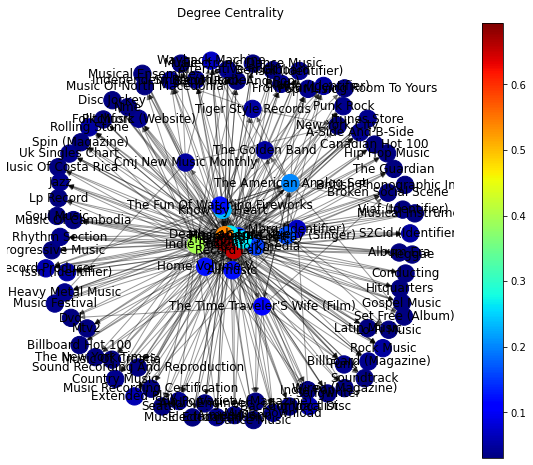

In [14]:
# the degree centrality of network(g)
fig, ax = plt.subplots(1,1,figsize=(10,8))

# layout position
pos = nx.spring_layout(g2,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.degree_centrality(g2)).values())

# draw edges
nx.draw_networkx_edges(g2,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(g2,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax)

# draw labels
nx.draw_networkx_labels(g2, pos=pos,
                        font_color='black', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.title("Degree Centrality")
plt.savefig('degree_centrality2.png', transparent=True,dpi=300)
plt.show()

In [15]:
nx.degree_centrality(g2)

{'New York City': 0.030612244897959183,
 'Indie Rock': 0.39795918367346933,
 'Folk Music': 0.030612244897959183,
 'Rock Music': 0.0510204081632653,
 'A-Side And B-Side': 0.04081632653061224,
 'Punk Rock': 0.04081632653061224,
 'Compact Disc': 0.061224489795918366,
 'The American Analog Set': 0.2040816326530612,
 'Music Festival': 0.04081632653061224,
 'Rolling Stone': 0.0510204081632653,
 'Electronic Dance Music': 0.030612244897959183,
 'Issn (Identifier)': 0.0510204081632653,
 'Musical Instrument': 0.030612244897959183,
 'Promise Of Love': 0.14285714285714285,
 'Aimee Mann': 0.030612244897959183,
 'S2Cid (Identifier)': 0.0510204081632653,
 "The Time Traveler'S Wife (Film)": 0.11224489795918366,
 'From Our Living Room To Yours': 0.030612244897959183,
 'Gospel Music': 0.030612244897959183,
 'Independent Record Label': 0.0510204081632653,
 'Isni (Identifier)': 0.04081632653061224,
 'Musical Ensemble': 0.030612244897959183,
 'Dance Music': 0.030612244897959183,
 'Latin Music': 0.030612244

O grafo acima ainda está de difícil visualização, devido à grande quantidade de nós com baixo grau. Em função disso, não conseguimos visualizar direito os nós com uma maior quantidade de conexões. Para solucionar o problema, podemos aplicar o filtro novamente, porém com um número maior na limitação de grau.

In [16]:
# filter nodes with degree greater than or equal to 2
core = [node for node, deg in dict(g.degree()).items() if deg >= 20]

# select a subgraph with 'core' nodes
gsub = nx.subgraph(g2, core)

print("{} nodes, {} edges".format(len(gsub), nx.number_of_edges(gsub)))

nx.write_graphml(gsub, "cna.graphml")

16 nodes, 42 edges


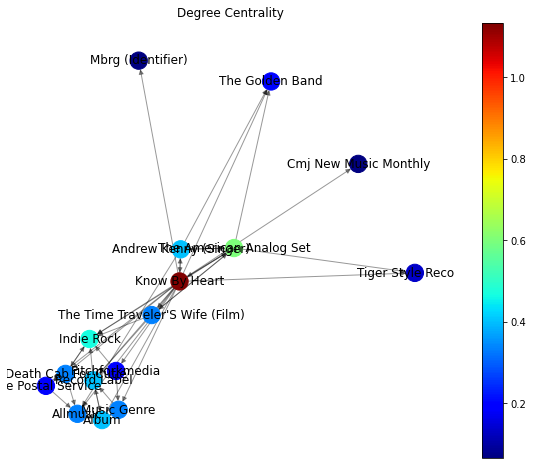

In [17]:
# the degree centrality of network(g)
fig, ax = plt.subplots(1,1,figsize=(10,8))

# layout position
pos = nx.spring_layout(gsub,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.degree_centrality(gsub)).values())

# draw edges
nx.draw_networkx_edges(gsub,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(gsub,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax)

# draw labels
nx.draw_networkx_labels(gsub, pos=pos,
                        font_color='black', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.title("Degree Centrality")
plt.savefig('degree_centrality.png', transparent=True,dpi=300)
plt.show()

É possível, agora, visualizar melhor os nós com maior quantidade de conexões.

### 2.2 Closeness centrality
A centralidade de proximidade verifica a distância entre os nós; quanto mais central for um nó, mais próximo ele estará de todos os outros nós.

In [18]:
nx.closeness_centrality(gsub)

{'Andrew Kenny (Singer)': 0.15000000000000002,
 "The Time Traveler'S Wife (Film)": 0.15000000000000002,
 'Know By Heart': 0.15000000000000002,
 'Pitchforkmedia': 0.13333333333333333,
 'Cmj New Music Monthly': 0.13333333333333333,
 'The Golden Band': 0.21333333333333335,
 'Indie Rock': 0.4245614035087719,
 'Record Label': 0.36666666666666664,
 'Album': 0.4245614035087719,
 'The American Analog Set': 0.2,
 'Mbrg (Identifier)': 0.13333333333333333,
 'The Postal Service': 0.26888888888888884,
 'Tiger Style Records': 0.17777777777777776,
 'Death Cab For Cutie': 0.2987654320987654,
 'Music Genre': 0.3361111111111111,
 'Allmusic': 0.32266666666666666}

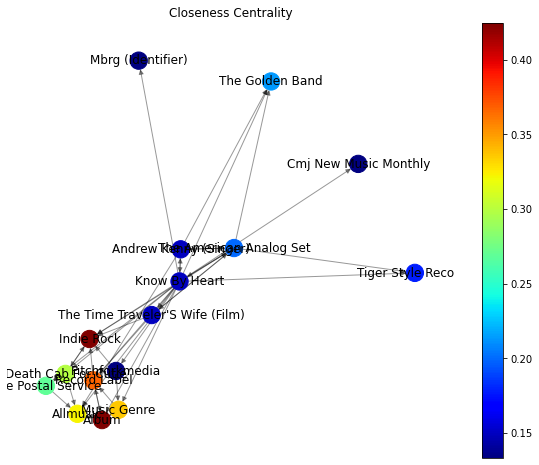

In [19]:
# the closeness centrality of network(g)
fig, ax = plt.subplots(1,1,figsize=(10,8))

# layout position
pos = nx.spring_layout(gsub,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.closeness_centrality(gsub)).values())

# draw edges
nx.draw_networkx_edges(gsub,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(gsub,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax)

# draw labels
nx.draw_networkx_labels(gsub, pos=pos,
                        font_color='black', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.title("Closeness Centrality")
plt.savefig('closeness_centrality.png', transparent=True,dpi=600)
plt.show()

### 2.3 Betweenness centrality
A centralidade de intermediação quantifica o número de vezes que um nó age como ponte ao longo do caminho mais curto entre dois outros nós.

In [20]:
nx.betweenness_centrality(gsub)

{'Andrew Kenny (Singer)': 0.003968253968253968,
 "The Time Traveler'S Wife (Film)": 0.002380952380952381,
 'Know By Heart': 0.09920634920634921,
 'Pitchforkmedia': 0.0,
 'Cmj New Music Monthly': 0.0,
 'The Golden Band': 0.0,
 'Indie Rock': 0.08253968253968254,
 'Record Label': 0.06904761904761905,
 'Album': 0.06904761904761905,
 'The American Analog Set': 0.048412698412698414,
 'Mbrg (Identifier)': 0.0,
 'The Postal Service': 0.0,
 'Tiger Style Records': 0.0,
 'Death Cab For Cutie': 0.07063492063492063,
 'Music Genre': 0.009523809523809525,
 'Allmusic': 0.05476190476190477}

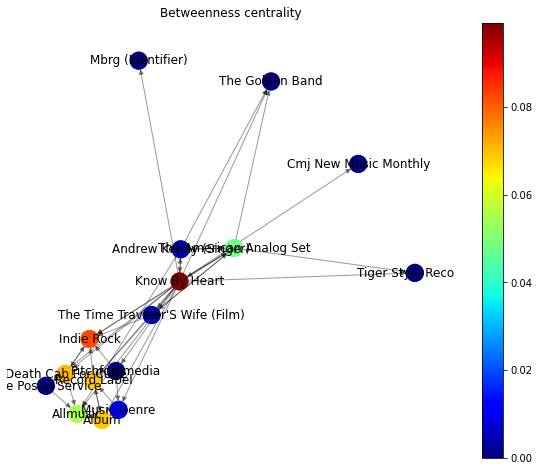

In [21]:
# the betwenness centrality of network(g)
fig, ax = plt.subplots(1,1,figsize=(10,8))

# layout position
pos = nx.spring_layout(gsub,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.betweenness_centrality(gsub)).values())

# draw edges
nx.draw_networkx_edges(gsub,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(gsub,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax)

# draw labels
nx.draw_networkx_labels(gsub, pos=pos,
                        font_color='black', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.title("Betweenness centrality")
plt.savefig('betweenness_centrality.png', transparent=True,dpi=600)
plt.show()

### 2.4 Eigenvector centrality
A centralidade de autovetor verifica a influência de um nó na rede.

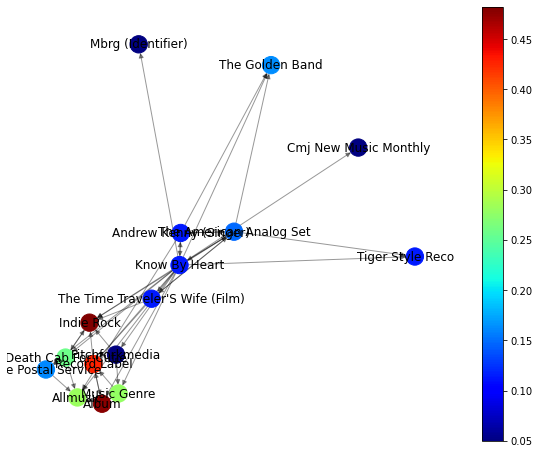

In [22]:
# the eigenvector centrality of network(g)
fig, ax = plt.subplots(1,1,figsize=(10,8))

# layout position
pos = nx.spring_layout(gsub,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.eigenvector_centrality(gsub)).values())

# draw edges
nx.draw_networkx_edges(gsub,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(gsub,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax)

# draw labels
nx.draw_networkx_labels(gsub, pos=pos,
                        font_color='black', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('eigenvector_centrality.png', transparent=True,dpi=600)
plt.show()

#3. Centrality distributions

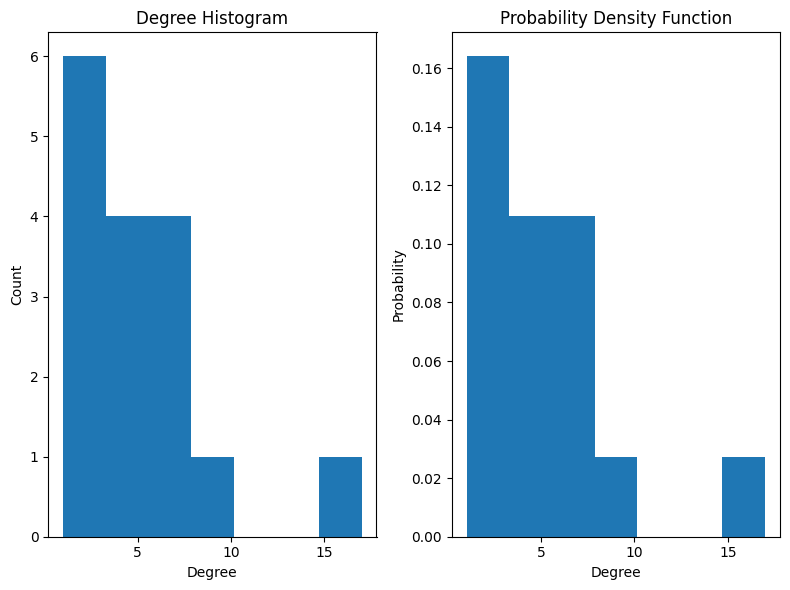

In [23]:
plt.style.use("default")
# degree sequence
degree_sequence = sorted([d for n, d in gsub.degree()], reverse=True)  

fig, ax = plt.subplots(1,2,figsize=(8,6))

# all_data has information about degree_sequence and the width of each bin
all_data = ax[0].hist(degree_sequence,bins=7)
ax[1].hist(degree_sequence,bins=7,density=True)

ax[0].set_title("Degree Histogram")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Degree")

ax[1].set_title("Probability Density Function")
ax[1].set_ylabel("Probability")
ax[1].set_xlabel("Degree")

plt.tight_layout()
plt.show()

In [24]:
print(all_data)

(array([6., 4., 4., 1., 0., 0., 1.]), array([ 1.        ,  3.28571429,  5.57142857,  7.85714286, 10.14285714,
       12.42857143, 14.71428571, 17.        ]), <a list of 7 Patch objects>)


In [25]:
# print the width of each bin
print(all_data[1])

[ 1.          3.28571429  5.57142857  7.85714286 10.14285714 12.42857143
 14.71428571 17.        ]


In [26]:
# calc the width of each bin using numpy
# diff calc the difference between two positions in the array
bin_width = np.diff(all_data[1])
bin_width

array([2.28571429, 2.28571429, 2.28571429, 2.28571429, 2.28571429,
       2.28571429, 2.28571429])

In [27]:
# total number of elements in array
all_data[0].sum()

16.0

In [28]:
# probability density function for each bin
# please check the right figure above and compare the results
all_data[0]/(all_data[0].sum() * bin_width)

array([0.1640625 , 0.109375  , 0.109375  , 0.02734375, 0.        ,
       0.        , 0.02734375])

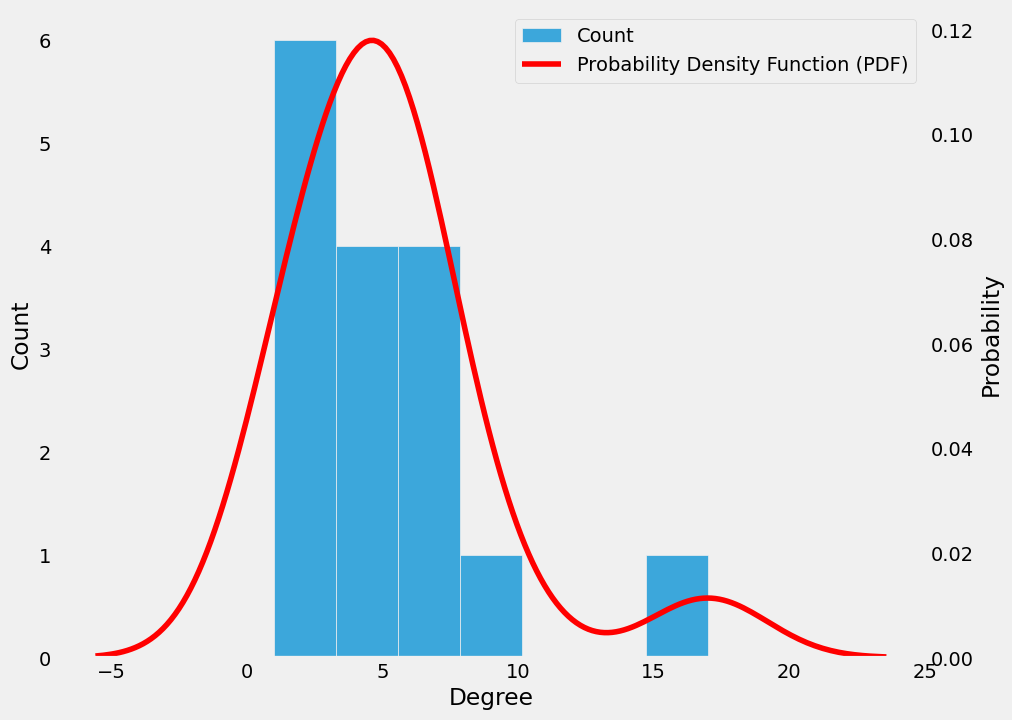

In [29]:
import seaborn as sns

plt.style.use("fivethirtyeight")
#plt.style.use("default")

fig, ax = plt.subplots(1,1,figsize=(10,8))

sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
ax2 = ax.twinx()
sns.kdeplot(degree_sequence,color='r',label="Probability Density Function (PDF)",ax=ax2)

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.grid(False)
ax2.grid(False)
ax.set_xlabel("Degree")
ax2.set_ylabel("Probability")

plt.savefig('probability_density_function.png', transparent=True,dpi=600,bbox_inches="tight")
plt.show()

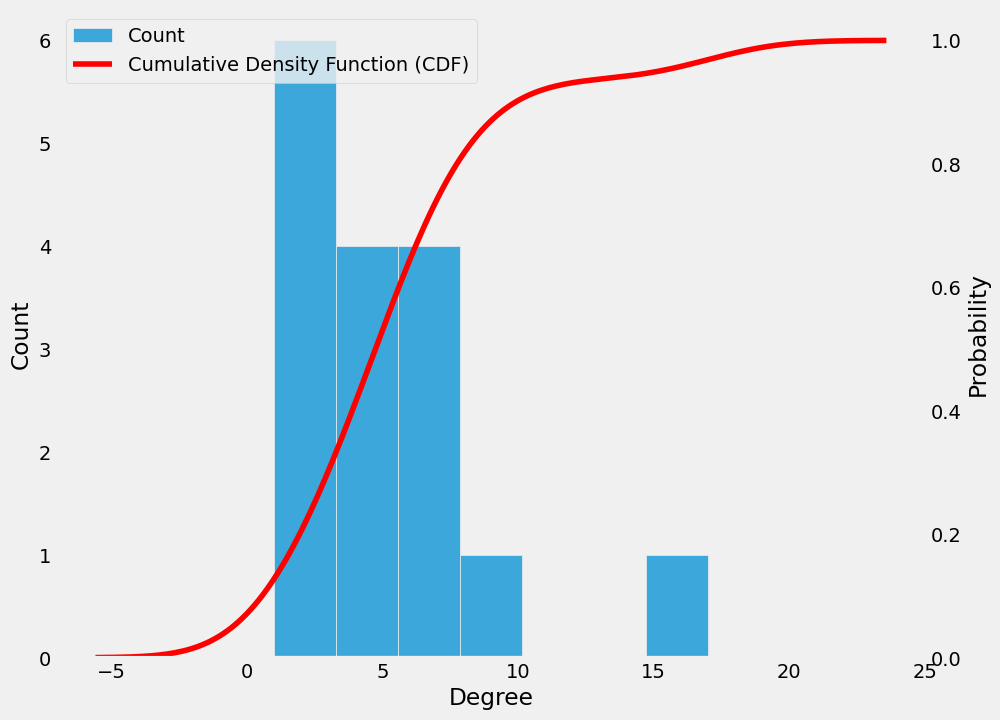

In [30]:
plt.style.use("fivethirtyeight")
#plt.style.use("default")

fig, ax = plt.subplots(1,1,figsize=(10,8))

sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
ax2 = ax.twinx()
sns.kdeplot(degree_sequence,color='r',label="Cumulative Density Function (CDF)",ax=ax2,cumulative=True)

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.grid(False)
ax2.grid(False)
ax.set_xlabel("Degree")
ax2.set_ylabel("Probability")

plt.savefig('cumulative_density_function.png', transparent=True,dpi=600,bbox_inches="tight")
plt.show()

#4. Distributions analysis

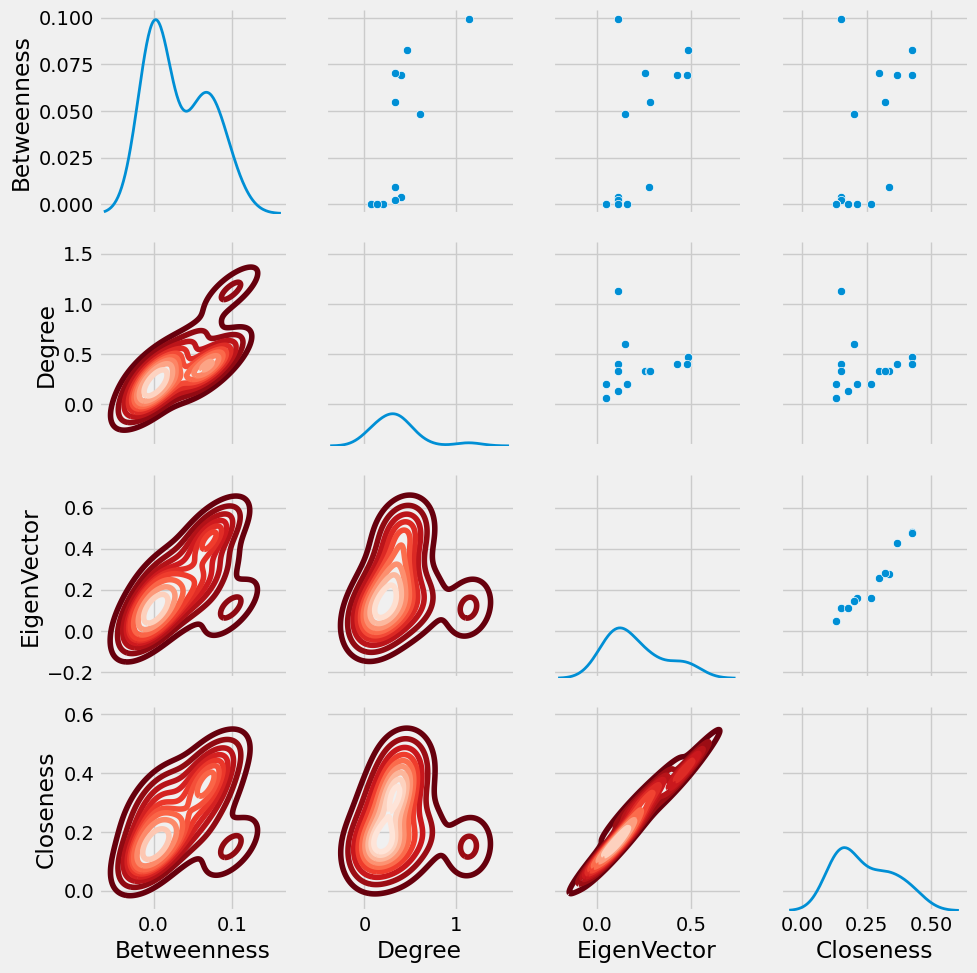

In [31]:
bc = pd.Series(nx.betweenness_centrality(gsub))
dc = pd.Series(nx.degree_centrality(gsub))
ec = pd.Series(nx.eigenvector_centrality(gsub))
cc = pd.Series(nx.closeness_centrality(gsub))

df = pd.DataFrame.from_dict({"Betweenness": bc,
                            "Degree": dc,
                            "EigenVector": ec,
                            "Closeness": cc})
df.reset_index(inplace=True,drop=True)
df.head()

fig = sns.PairGrid(df)
fig.map_upper(sns.scatterplot)
fig.map_lower(sns.kdeplot, cmap="Reds_r")
fig.map_diag(sns.kdeplot, lw=2, legend=False)

plt.savefig('all.png', transparent=True,dpi=800,bbox_inches="tight")
plt.show()


#5. Core decomposition

In [32]:
# k-core of the network
# 1-core
# 2-core
# 3-core
set([v for k,v in nx.core_number(g).items()])

{1, 2, 3, 4, 5, 6}

In [33]:
# 
# Change the variable core to visualize the nodes in k-core
# Note that 0-core is the all network
core = 3
for i in nx.k_core(g,core):
  print(i)
     

New York City
Indie Rock
Folk Music
Rock Music
A-Side And B-Side
Punk Rock
Compact Disc
The American Analog Set
Music Festival
Rolling Stone
Electronic Dance Music
Issn (Identifier)
Musical Instrument
Promise Of Love
Aimee Mann
S2Cid (Identifier)
The Time Traveler'S Wife (Film)
From Our Living Room To Yours
Gospel Music
Independent Record Label
Isni (Identifier)
Musical Ensemble
Dance Music
Latin Music
Pitchfork (Website)
Broken Social Scene
Uk Singles Chart
Songwriter
Conducting
Music Of Cambodia
Reggae
Pitchforkmedia
Mbrg (Identifier)
Tiger Style Records
The New York Times
British Phonographic Industry
Ben Gibbard
Disc Jockey
Death Cab For Cutie
Know By Heart
The Golden Band
Music Download
Country Music
Set Free (Album)
Record Label
Music Of North Macedonia
Dvd
Alternative Rock
Lo-Fi Music
Spin (Magazine)
Backing Vocalist
Home Volume V
Viaf (Identifier)
Blues
Single (Music)
Album Era
Heavy Metal Music
Itunes Store
Progressive Music
The Guardian
Rhythm Section
Music Of Costa Rica
Vari

In [34]:
# 
# Change the variable shell to visualize the nodes in k-shell
# Note that vertices in k-shell are member of k-core, however they are not member of (k+1)-core
shell = 3
for i in nx.k_shell(g,shell):
  print(i)

Music Of Cambodia
Reggae
New York City
Album Era
Viaf (Identifier)
Folk Music
Progressive Music
The New York Times
The Guardian
British Phonographic Industry
Ben Gibbard
Music
Music Education
Music Of Costa Rica
Variety (Magazine)
Audio Engineer
Disc Jockey
Music Festival
Electronic Dance Music
Musical Instrument
Hitquarters
Hip Hop Music
Billboard Hot 100
Band (Rock And Pop)
Music Recording Certification
Aimee Mann
Sound Recording And Reproduction
From Our Living Room To Yours
Lp Record
Set Free (Album)
Gospel Music
Nme
Canadian Hot 100
Music Of North Macedonia
Mtv2
Dvd
Indie Pop
Seattle
Musical Ensemble
Soul Music
Dance Music
Lo-Fi Music
Spin (Magazine)
Wired (Magazine)
Cmj New Music Monthly
Latin Music
Backing Vocalist
Broken Social Scene
Soundtrack
Songwriter
Music Of Croatia
Conducting


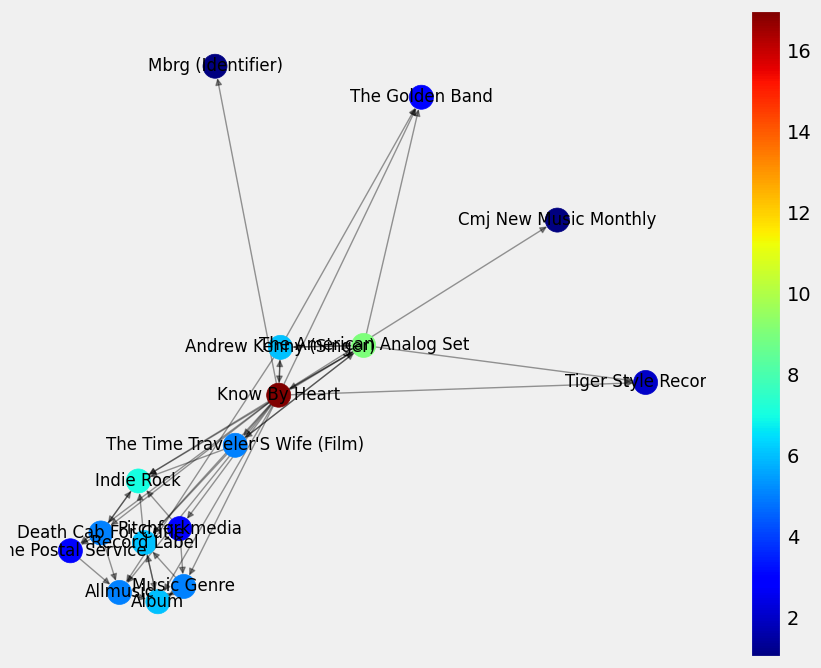

In [35]:
# the degree of network(g2)
fig, ax = plt.subplots(1,1,figsize=(10,8))

# layout position
pos = nx.spring_layout(gsub,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.degree(gsub)).values())

# draw edges
nx.draw_networkx_edges(gsub,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(gsub,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,ax=ax)

# draw labels
nx.draw_networkx_labels(gsub, pos=pos,
                        font_color='black', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('sociopatterns.png', transparent=True,dpi=600)
plt.show()

In [36]:
# How many k-cores does this network have?
set([v for k,v in nx.core_number(gsub).items()])

{1, 2, 3, 4}

In [37]:
# 1-core is composed for all vertices in the network because this network is connected
len([gsub.degree(node) for node in list(nx.k_core(gsub,1))])

16

In [38]:
# how to calculate shell by hands
a = [node for node in list(nx.k_core(gsub,1))]
b = [node for node in list(nx.k_core(gsub,2))]
np.setxor1d(a,b)

array(['Cmj New Music Monthly', 'Mbrg (Identifier)'], dtype='<U31')

In [39]:
# who are in the innermost core
print(list(nx.k_shell(gsub,3)))

['The Postal Service', 'Pitchforkmedia', 'The Golden Band']


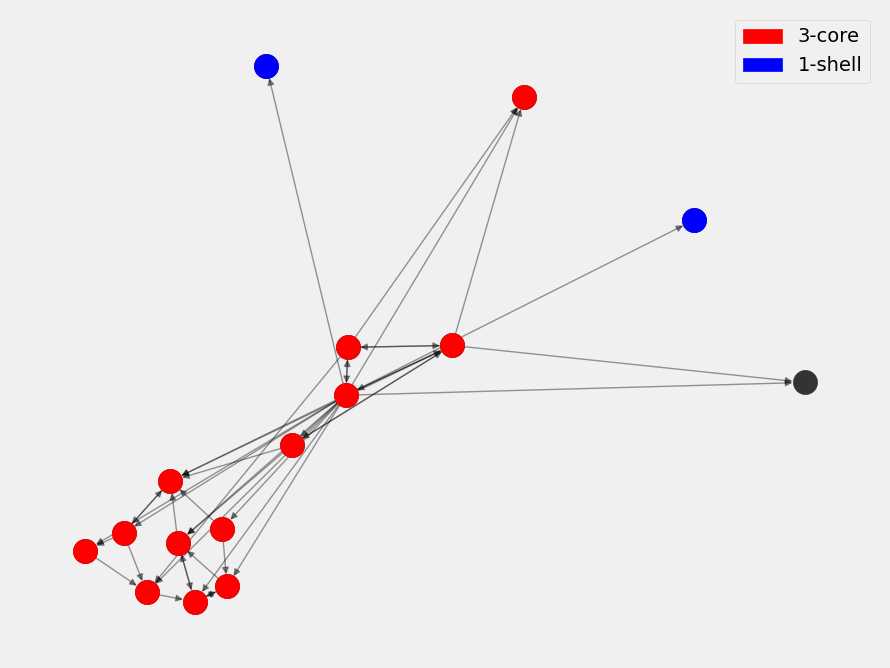

In [40]:
import matplotlib.patches as mpatches

# the degree of network(g2)
fig, ax = plt.subplots(1,1,figsize=(10,8))

# Find k-cores
gsub_core_1 = nx.k_shell(gsub, 1)
gsub_core_3 = nx.k_core(gsub, 3)

# layout position
pos = nx.spring_layout(gsub,seed=123456789,k=0.3)

# draw edges
nx.draw_networkx_edges(gsub,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(gsub,
                 pos=pos,
                 node_color="#333333")

# draw nodes
nodes = nx.draw_networkx_nodes(gsub_core_1,
                 pos=pos,
                 node_color="blue")

nodes = nx.draw_networkx_nodes(gsub_core_3,
                 pos=pos,
                 node_color="red")

# static legend
red_patch = mpatches.Patch(color='red', label='3-core')
blue_patch = mpatches.Patch(color='blue', label='1-shell')
plt.legend(handles=[red_patch,blue_patch])

plt.axis("off")
plt.savefig('k-core_sociopatterns.png', transparent=True,dpi=600)
plt.show()